# Lab 5 - Ensembles 
Here is what we will do:
1. Create a data set with two input features and a 3 category target
2. Train a decision tree on the data set for a baseline
3. Train 3 ensemble models
    - Serial Ada Boosted DT
    - Decision Forest
    - Ensemble of DT, SVM, and NN
3. Get model performance on train and test sets
4. Create appropriate graphs
5. Do a 10 fold cross validation with a DT model

### Prepare the data

### Settings for the generated dataset
This data set will be spirals with noise
arms - This is the number of categories we will have
turns - How many times we go around the spiral
width - How wide is the spiral (percentage of the radius)
noise - How much noise we will add to the data.
size - The number of points to generate

In [75]:
arms = 3
turns = 2
width = 0.3
noise = .25
size = 5000

### The spirals will be based on the equation r=theta

Build set
Arm 0
Using offset 0.0
Arm 1
Using offset 2.0943951023931953
Arm 2
Using offset 4.1887902047863905


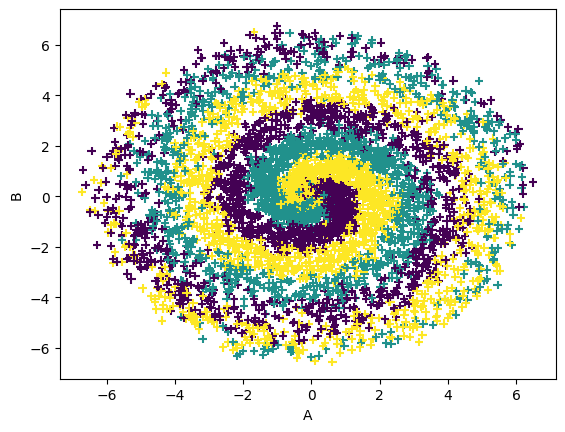

In [76]:
import numpy as np
import pandas as pd


def build_arm(n):
    print("Arm", n)
    points_per_arm = int(size/arms)
    #Get points on the curve
    theta_values = np.random.uniform(0, np.pi*turns, points_per_arm)
    r_values = theta_values
    target_values = [n] * points_per_arm
    
    #Add make the arm wider
    lower_fraction = (1 - width)*theta_values
    upper_fraction = (1 + width)*theta_values
    difference = upper_fraction - lower_fraction
    location = np.random.uniform(0, 1, points_per_arm)
    theta_values = theta_values + lower_fraction + difference*location
    
    #offset angle 
    offset = n*2*np.pi/arms
    print('Using offset', offset)
    theta_values = theta_values + offset
    
    #draw the noise from a distribution centered on 0.0 with a standard deviation of noise
    x_noise_values = np.random.normal(0, noise, points_per_arm)
    y_noise_values = np.random.normal(0, noise, points_per_arm)
    x_values = r_values * np.sin(theta_values) + x_noise_values
    y_values = r_values * np.cos(theta_values) + y_noise_values
    
    
    return x_values, y_values, target_values
    

def build_set():
    data_x = np.array([])
    data_y = np.array([])
    data_t = np.array([])
    print("Build set")
    for i in range(0,arms):
        x, y, t = build_arm(i)
        #print(data_x)
        #print(x)
        #print(y)
        #print(t)
        # add each arm to the data set
        data_x=np.append(data_x, x)
        data_y=np.append(data_y, y)
        data_t=np.append(data_t, t)
     # create a dictionary with each feature
    d = {}
    d["A"] = data_x
    d["B"] = data_y
    d["Class"] = data_t

    #print(d)

    # Create the data frame from the dictionary
    
    dataframe = pd.DataFrame(data=d)
    return dataframe
    

spiral = build_set()

import matplotlib.pyplot as plt

#shuffle before plotting so we don't always overwrite with the same color
shuffled = spiral.sample(frac=1)
plt.scatter(shuffled['A'], shuffled['B'], c=shuffled['Class'], marker='+')

plt.xlabel('A')
plt.ylabel('B')
plt.show()
    




### Stratified Test/Train Data Split

In [77]:
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=123)
for train_indices, test_indices in splitter.split(spiral, spiral['Class']):
    train_set = spiral.iloc[train_indices]
    test_set = spiral.iloc[test_indices]
    



### A Helpful plotting function for showing true and false for the categories

In [78]:
import matplotlib.pyplot as plt

def plot2FeatureBinaryConfusion(data_set, feature1Label, feature2Label, targetLabel, predicted, positive=1, negative=0):
## assumes that the target is 0/1

    
    target = data_set[targetLabel]
    
    # Filter with feature 1
    feature1_positives = np.ma.masked_where(target==negative, 
                     data_set[feature1Label])
    true_positive = np.ma.masked_where(predicted!=target, feature1_positives)
    false_negative = np.ma.masked_where(predicted==target, feature1_positives)
    feature1_negatives = np.ma.masked_where(target==positive, 
                     data_set[feature1Label])
    true_negative = np.ma.masked_where(predicted!=target, feature1_negatives)
    false_positive = np.ma.masked_where(predicted==target,feature1_negatives)

   
    feature2 = data_set[feature2Label]
    plt.scatter(true_positive, feature2, c='green', marker='o')
    plt.scatter(false_positive, feature2, c='red', marker='^')
    plt.scatter(true_negative, feature2, c='blue', marker='o')
    plt.scatter(false_negative, feature2, c='orange', marker='^')



    plt.xlabel(feature1Label)
    plt.ylabel(feature2Label)
    plt.legend(['True Positive', 'False Positive', 'True Negative', 'False Negative'])
    plt.show()

### Train and evaluate Decision Tree model 

In [79]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import precision_score, recall_score
  

X = train_set[['A','B' ]]
y = train_set['Class']

X_test = test_set[['A','B']]
y_test = test_set['Class']

tree_model = DecisionTreeClassifier()
tree_model.fit(X,y)

y_pred = tree_model.predict(X)
print('Results for decision tree on training data')
print('  Default settings')
print("Confusion Matrix")
print(confusion_matrix(y, y_pred))
print('Accuracy is  ', accuracy_score(y, y_pred))
print('Precision is ', precision_score(y, y_pred, average='weighted'))
print('Recall is    ', recall_score(y,y_pred, average='weighted'))
print('F1 is        ', f1_score(y, y_pred, average='weighted'))
print()

y_test_pred = tree_model.predict(X_test)
print('Results for decision tree on test data')
print('  Default settings')
print("Confusion Matrix")
print(confusion_matrix(y_test, y_test_pred))
print('Accuracy is  ', accuracy_score(y_test, y_test_pred))
print('Precision is ', precision_score(y_test, y_test_pred, average='weighted'))
print('Recall is    ', recall_score(y_test,y_test_pred, average='weighted'))
print('F1 is        ', f1_score(y_test, y_test_pred, average='weighted'))



Results for decision tree on training data
  Default settings
Confusion Matrix
[[1333    0    0]
 [   0 1333    0]
 [   0    0 1332]]
Accuracy is   1.0
Precision is  1.0
Recall is     1.0
F1 is         1.0

Results for decision tree on test data
  Default settings
Confusion Matrix
[[232  50  51]
 [ 54 229  50]
 [ 53  62 219]]
Accuracy is   0.68
Precision is  0.6801026212921392
Recall is     0.68
F1 is         0.6798985439328592


### Train and evaluate SVC model 

In [80]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import precision_score, recall_score
  

X = train_set[['A','B' ]]
y = train_set['Class']

X_test = test_set[['A','B']]
y_test = test_set['Class']

svc_model = SVC()
svc_model.fit(X,y)

y_pred = svc_model.predict(X)
print('Results for svc on training data')
print('  Default settings')
print("Confusion Matrix")
print(confusion_matrix(y, y_pred))
print('Accuracy is  ', accuracy_score(y, y_pred))
print('Precision is ', precision_score(y, y_pred, average='weighted'))
print('Recall is    ', recall_score(y,y_pred, average='weighted'))
print('F1 is        ', f1_score(y, y_pred, average='weighted'))
print()

y_test_pred = svc_model.predict(X_test)
print('Results for svc on test data')
print('  Default settings')
print("Confusion Matrix")
print(confusion_matrix(y_test, y_test_pred))
print('Accuracy is  ', accuracy_score(y_test, y_test_pred))
print('Precision is ', precision_score(y_test, y_test_pred, average='weighted'))
print('Recall is    ', recall_score(y_test,y_test_pred, average='weighted'))
print('F1 is        ', f1_score(y_test, y_test_pred, average='weighted'))



Results for svc on training data
  Default settings
Confusion Matrix
[[605 393 335]
 [361 617 355]
 [375 439 518]]
Accuracy is   0.4352176088044022
Precision is  0.4352598483560316
Recall is     0.4352176088044022
F1 is         0.43465516540701576

Results for svc on test data
  Default settings
Confusion Matrix
[[134 101  98]
 [ 97 152  84]
 [107 106 121]]
Accuracy is   0.407
Precision is  0.4063889328871244
Recall is     0.407
F1 is         0.40617904768540336


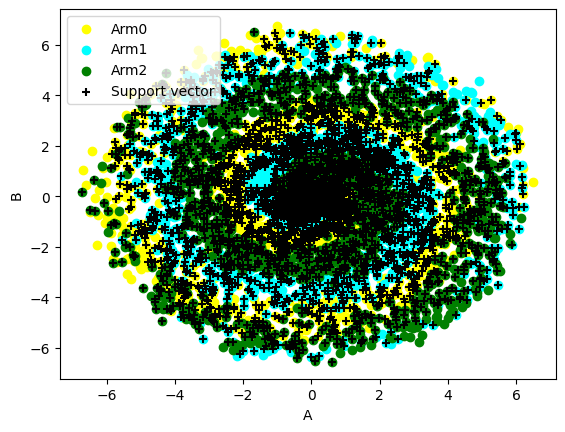

In [81]:
import matplotlib.pyplot as plt
arm0_A = np.ma.masked_where(spiral['Class']!=0, 
                     spiral['A'])

arm1_A = np.ma.masked_where(spiral['Class']!=1, 
                     spiral['A'])

arm2_A = np.ma.masked_where(spiral['Class']!=2, 
                     spiral['A'])



# get the values for the support vectors (the special instances)
support_x = [x for (x,y) in svc_model.support_vectors_]
support_y = [y for (x,y) in svc_model.support_vectors_]




b = spiral['B']
plt.scatter(arm0_A, b, c='yellow', marker='o')
plt.scatter(arm1_A, b, c='cyan', marker='o')
plt.scatter(arm2_A, b, c='green', marker='o')
plt.scatter(support_x, support_y, c='black', marker='+')

plt.xlabel('A')
plt.ylabel('B')
plt.legend(['Arm0', 'Arm1', 'Arm2','Support vector'])
plt.show()

### Train and evaluate Neural Net model 

In [82]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import precision_score, recall_score
  

X = train_set[['A','B' ]]
y = train_set['Class']

X_test = test_set[['A','B']]
y_test = test_set['Class']

nn_model = MLPClassifier(hidden_layer_sizes=(50, 25, 10),
                         solver='lbfgs')
nn_model.fit(X,y)

y_pred = nn_model.predict(X)


print('Results for NN on train data')
print('  Default settings')
print("Confusion Matrix")
print(confusion_matrix(y, y_pred))
print('Accuracy is  ', accuracy_score(y, y_pred))
print('Precision is ', precision_score(y, y_pred, average='weighted'))
print('Recall is    ', recall_score(y,y_pred, average='weighted'))
print('F1 is        ', f1_score(y, y_pred, average='weighted'))
print()

y_test_pred = nn_model.predict(X_test)
print('Results for NN on test data')
print('  Default settings')
print("Confusion Matrix")
print(confusion_matrix(y_test, y_test_pred))
print('Accuracy is  ', accuracy_score(y_test, y_test_pred))
print('Precision is ', precision_score(y_test, y_test_pred, average='weighted'))
print('Recall is    ', recall_score(y_test,y_test_pred, average='weighted'))
print('F1 is        ', f1_score(y_test, y_test_pred, average='weighted'))




Results for NN on train data
  Default settings
Confusion Matrix
[[1067  147  119]
 [ 130 1037  166]
 [ 147  149 1036]]
Accuracy is   0.7853926963481741
Precision is  0.7853661608243202
Recall is     0.7853926963481741
F1 is         0.78537046748517

Results for NN on test data
  Default settings
Confusion Matrix
[[263  34  36]
 [ 50 247  36]
 [ 42  46 246]]
Accuracy is   0.756
Precision is  0.7566108770330133
Recall is     0.756
F1 is         0.7558723806404752


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


### Train and evaluate ADA boosted model

In [83]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import precision_score, recall_score
  

X = train_set[['A','B']]
y = train_set['Class']

X_test = test_set[['A','B']]
y_test = test_set['Class']

ada_model = AdaBoostClassifier(n_estimators=150)
ada_model.fit(X,y)

y_pred = ada_model.predict(X)


print('Results for ADA on training data')
print('  Default settings')
print("Confusion Matrix")
print(confusion_matrix(y, y_pred))
print('Accuracy is  ', accuracy_score(y, y_pred))
print('Precision is ', precision_score(y, y_pred, average='weighted'))
print('Recall is    ', recall_score(y,y_pred, average='weighted'))
print('F1 is        ', f1_score(y, y_pred, average='weighted'))
print()

y_test_pred = ada_model.predict(X_test)
print('Results for ADA on test data')
print('  Default settings')
print("Confusion Matrix")
print(confusion_matrix(y_test, y_test_pred))
print('Accuracy is  ', accuracy_score(y_test, y_test_pred))
print('Precision is ', precision_score(y_test, y_test_pred, average='weighted'))
print('Recall is    ', recall_score(y_test,y_test_pred, average='weighted'))
print('F1 is        ', f1_score(y_test, y_test_pred, average='weighted'))




/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Results for ADA on training data
  Default settings
Confusion Matrix
[[807 258 268]
 [331 738 264]
 [265 293 774]]
Accuracy is   0.580040020010005
Precision is  0.5801242578529078
Recall is     0.580040020010005
F1 is         0.5798814447171041

Results for ADA on test data
  Default settings
Confusion Matrix
[[206  68  59]
 [107 176  50]
 [ 91  87 156]]
Accuracy is   0.538
Precision is  0.5434793417362599
Recall is     0.538
F1 is         0.5366547515382111


### Train and evaluate Random Forest model

In [84]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import precision_score, recall_score
  

X = train_set[['A','B']]
y = train_set['Class']

X_test = test_set[['A','B']]
y_test = test_set['Class']

rf_model = RandomForestClassifier(n_estimators=150)
rf_model.fit(X,y)

y_pred = rf_model.predict(X)


print('Results for Random Forest on training data')
print('  Default settings')
print("Confusion Matrix")
print(confusion_matrix(y, y_pred))
print('Accuracy is  ', accuracy_score(y, y_pred))
print('Precision is ', precision_score(y, y_pred, average='weighted'))
print('Recall is    ', recall_score(y,y_pred, average='weighted'))
print('F1 is        ', f1_score(y, y_pred, average='weighted'))
print()

y_test_pred = rf_model.predict(X_test)
print('Results for Random Forest on test data')
print('  Default settings')
print("Confusion Matrix")
print(confusion_matrix(y_test, y_test_pred))
print('Accuracy is  ', accuracy_score(y_test, y_test_pred))
print('Precision is ', precision_score(y_test, y_test_pred, average='weighted'))
print('Recall is    ', recall_score(y_test,y_test_pred, average='weighted'))
print('F1 is        ', f1_score(y_test, y_test_pred, average='weighted'))




Results for Random Forest on training data
  Default settings
Confusion Matrix
[[1333    0    0]
 [   0 1333    0]
 [   0    0 1332]]
Accuracy is   1.0
Precision is  1.0
Recall is     1.0
F1 is         1.0

Results for Random Forest on test data
  Default settings
Confusion Matrix
[[250  37  46]
 [ 46 247  40]
 [ 47  44 243]]
Accuracy is   0.74
Precision is  0.7401696232833707
Recall is     0.74
F1 is         0.740002735573994


### Train and evaluate Voting model
We build it out of three different kinds of classifiers
One each of DT, SVC, and NN

In [85]:
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import precision_score, recall_score
  
# Build the classifiers
vc1_dt = DecisionTreeClassifier()
vc2_svm = SVC()
vc3_nn  =  MLPClassifier(hidden_layer_sizes=(50, 25, 10),
                         solver='lbfgs')

# Bundle into a list with names
vcList = [('DT',vc1_dt),
    ('SVM',vc2_svm),
    ('NN',vc3_nn)]

X = train_set[['A','B']]
y = train_set['Class']

X_test = test_set[['A','B']]
y_test = test_set['Class']

vote_model = VotingClassifier(vcList)
vote_model.fit(X,y)

y_pred = vote_model.predict(X)


print('Results for Voting Ensemble on training data')
print('  Default settings')
print("Confusion Matrix")
print(confusion_matrix(y, y_pred))
print('Accuracy is  ', accuracy_score(y, y_pred))
print('Precision is ', precision_score(y, y_pred, average='weighted'))
print('Recall is    ', recall_score(y,y_pred, average='weighted'))
print('F1 is        ', f1_score(y, y_pred, average='weighted'))
print()

y_test_pred = vote_model.predict(X_test)
print('Results for Voting Ensemble on test data')
print('  Default settings')
print("Confusion Matrix")
print(confusion_matrix(y_test, y_test_pred))
print('Accuracy is  ', accuracy_score(y_test, y_test_pred))
print('Precision is ', precision_score(y_test, y_test_pred, average='weighted'))
print('Recall is    ', recall_score(y_test,y_test_pred, average='weighted'))
print('F1 is        ', f1_score(y_test, y_test_pred, average='weighted'))




/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Results for Voting Ensemble on training data
  Default settings
Confusion Matrix
[[1233   67   33]
 [ 112 1137   84]
 [ 225   55 1052]]
Accuracy is   0.855927963981991
Precision is  0.8627782042341331
Recall is     0.855927963981991
F1 is         0.8560184826694888

Results for Voting Ensemble on test data
  Default settings
Confusion Matrix
[[268  36  29]
 [ 59 235  39]
 [ 79  46 209]]
Accuracy is   0.712
Precision is  0.7186812268365502
Recall is     0.712
F1 is         0.710808547402271


### Cross Validate a Decision Tree model

In [86]:
from sklearn.model_selection import StratifiedKFold

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix

accuracy_list = np.array([])
f1_list = np.array([])

splitter = StratifiedKFold(n_splits=10, shuffle=True, random_state=123)
for train_indices, validate_indices in splitter.split(spiral,
spiral['Class']):
    train_set = spiral.iloc[train_indices]
    validate_set = spiral.iloc[validate_indices]
    X = train_set[['A','B' ]]
    y = train_set['Class']
    X_validate = validate_set[['A','B']]
    y_validate = validate_set['Class']

model = DecisionTreeClassifier()
model.fit(X,y)
y_validate_pred = model.predict(X_validate)
accuracy = accuracy_score(y_validate, y_validate_pred)
print("Confusion Matrix")
print(confusion_matrix(y_validate, y_validate_pred))
print('Accuracy is ', accuracy)
accuracy_list = np.insert(accuracy_list, 0, accuracy)

print("Accuracy values", accuracy_list)
print("   Average of ", np.average(accuracy_list))
print("   StDev of ", np.std(accuracy_list))


Confusion Matrix
[[122  20  24]
 [ 24 119  24]
 [ 18  28 120]]
Accuracy is  0.7234468937875751
Accuracy values [0.72344689]
   Average of  0.7234468937875751
   StDev of  0.0


# Results
Basic results for our classification model to predict arm on the spiral data set

| Model | Training Features | Acc Train | F1 Train |Acc Test | F1 Test |
|:---|:---|:---|:---|:---|:---|
|Decision Tree|A,B|100.0|100.0|71.62 | 71.63 |
|SVC|A,B|71.58|71.58|70.5|70.42|
|MLP|A,B layers (50,25,10) lbfgs|80.06|80.13|77.87|77.91
|ADA|A,B 150 estimators|65.08|65.05|63.5|63.49|
|RF|A,B 150 estimators|100|100|80.13|80.13|
|VC|A,B, MLP layers (50,25,10)|88.62|88.63|80.75|80.76|